Image Captcha is python library to create captcha.
```python
pip install captcha
```
We will use this library and create a CNN to predict the captcha
#### Let's import libraries


In [1]:
from captcha.image import ImageCaptcha
import numpy as np
import os
from PIL import Image
import random
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
num_alpha=['0','1','2','3','4','5','6','7','8','9',
           'q','w','e','r','t','y','u','i','o','p',
           'a','s','d','f','g','h','j','k','l','z',
           'x','c','v','b','n','m',
           'Q','W','E','R','T','Y','U','I','O','P',
           'A','S','D','F','G','H','J','K','L','Z',
           'X','C','V','B','N','M']
#tol num = training set + test set +validation set
height = 60
width = 160

In [3]:
def random_captcha_text(char_set=num_alpha, captcha_size=6):
    captcha_text = []
    for i in range(captcha_size):
        c = random.choice(char_set)
        captcha_text.append(c)
    return captcha_text

In [4]:
def gen_captcha_text_and_image(i):
    image = ImageCaptcha(width=160,height=60,font_sizes=[30])
    
    captcha_text = random_captcha_text()
    captcha_text = ''.join(captcha_text)
    
    captcha = image.generate(captcha_text)
        
    captcha_image=Image.open(captcha)
    
    if i == 0:
        print('printing 1st captcha')
        imshow(np.asarray(captcha_image) )
        
    captcha_arr = np.asarray(captcha_image, dtype="float32")
    #print(captcha_arr.shape)
    return captcha_text, captcha_arr

TQDM is python library to know the progress of loops

In [5]:
from tqdm import *

In [6]:
tol_num = 20010

  0%|          | 0/20010 [00:00<?, ?it/s]

printing 1st captcha


100%|██████████| 20010/20010 [01:47<00:00, 186.13it/s]


-----------captchas generated------------


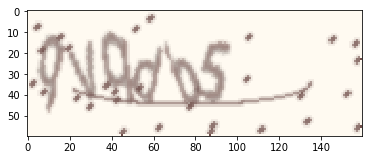

In [7]:
#y_len is length of output vector which contains 10 numbers, 26 upper case letter, 26 lower case letters multiplied by 6 captcha letter
y_len = 6*(10+26+26)
channel = 3 #RGB Image
data = np.empty((tol_num,height,width,channel),dtype="float32")
label = np.empty((tol_num,y_len),dtype="uint8")

for i in tqdm( range(tol_num) ):
    text, arr = gen_captcha_text_and_image(i)
    data[i,:,:,:] = arr
    vector = np.zeros(6*(10+26+26))
    for j,c in enumerate(text):
        idx = j*(10+26+26) + num_alpha.index(c)
        vector[idx]=1
    label[i]=vector
print('-----------captchas generated------------')
#data, shuffled and split between train and test sets



randomising the data

In [8]:
val_minus = tol_num-10

rr = [i for i in range(val_minus)]
random.shuffle(rr)

In [9]:
train_num=16000

X_train = data[rr][:train_num]

In [10]:
y_train = label[rr][:train_num]

In [11]:
X_test = data[rr][train_num:]

In [12]:
y_test = label[rr][train_num:]

In [13]:
val_set = data[(val_minus+1):]

In [14]:
X_train.shape

(16000, 60, 160, 3)

# Lets create the model

In [15]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, MaxPooling2D, Convolution2D, Dropout

Using TensorFlow backend.


In [25]:
captcha_cnn = Sequential([
    Convolution2D(64,2,2,input_shape=(height,width,channel), activation='relu'),
    MaxPooling2D(pool_size=(2,2) ),
    Dropout(0.25),
    
    Convolution2D(128,2,2,activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Convolution2D(128,2,2,activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(500,activation='relu'),
    Dense(250,activation='relu'),
    Dense(6*(10+26+26), activation='softmax')
])

C:\Users\Chaitra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), input_shape=(60, 160, ..., activation="relu")`
  
C:\Users\Chaitra\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), activation="relu")`
  
C:\Users\Chaitra\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.


In [26]:
captcha_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 59, 159, 64)       832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 79, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 79, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 78, 128)       32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 39, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 39, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 38, 128)       65664     
__________

In [27]:
captcha_cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [28]:
captcha_cnn.fit(X_train,y_train, 
          epochs=1, 
          batch_size=3, 
          validation_data=(X_test,y_test)
         )

Train on 16000 samples, validate on 4000 samples
Epoch 1/1


  930/16000 [>.............................] - ETA: 11275s - loss: 96.70 - ETA: 5891s - loss: 96.7086 - ETA: 4104s - loss: 96.708 - ETA: 3210s - loss: 96.708 - ETA: 2657s - loss: 96.708 - ETA: 2303s - loss: 96.520 - ETA: 2050s - loss: 96.547 - ETA: 1860s - loss: 96.567 - ETA: 1711s - loss: 96.583 - ETA: 1584s - loss: 96.596 - ETA: 1489s - loss: 96.606 - ETA: 1406s - loss: 96.614 - ETA: 1335s - loss: 96.622 - ETA: 1276s - loss: 96.628 - ETA: 1227s - loss: 96.633 - ETA: 1183s - loss: 96.638 - ETA: 1145s - loss: 96.642 - ETA: 1110s - loss: 96.646 - ETA: 1080s - loss: 96.366 - ETA: 1051s - loss: 96.383 - ETA: 1023s - loss: 96.399 - ETA: 1000s - loss: 96.413 - ETA: 978s - loss: 96.426 - ETA: 961s - loss: 96.43 - ETA: 943s - loss: 96.44 - ETA: 925s - loss: 96.45 - ETA: 909s - loss: 96.46 - ETA: 896s - loss: 96.28 - ETA: 883s - loss: 96.29 - ETA: 868s - loss: 96.31 - ETA: 857s - loss: 96.32 - ETA: 847s - loss: 96.33 - ETA: 837s - loss: 96.34 - ETA: 828s - loss: 96.35 - ETA: 819s - loss: 96.36

 1872/16000 [==>...........................] - ETA: 523s - loss: 96.37 - ETA: 522s - loss: 96.37 - ETA: 522s - loss: 96.37 - ETA: 522s - loss: 96.37 - ETA: 522s - loss: 96.38 - ETA: 522s - loss: 96.38 - ETA: 521s - loss: 96.38 - ETA: 521s - loss: 96.38 - ETA: 521s - loss: 96.38 - ETA: 521s - loss: 96.38 - ETA: 521s - loss: 96.37 - ETA: 520s - loss: 96.37 - ETA: 520s - loss: 96.37 - ETA: 520s - loss: 96.37 - ETA: 520s - loss: 96.37 - ETA: 519s - loss: 96.37 - ETA: 519s - loss: 96.37 - ETA: 519s - loss: 96.37 - ETA: 519s - loss: 96.37 - ETA: 519s - loss: 96.37 - ETA: 519s - loss: 96.38 - ETA: 518s - loss: 96.38 - ETA: 518s - loss: 96.38 - ETA: 518s - loss: 96.38 - ETA: 518s - loss: 96.38 - ETA: 518s - loss: 96.36 - ETA: 517s - loss: 96.37 - ETA: 517s - loss: 96.37 - ETA: 517s - loss: 96.35 - ETA: 517s - loss: 96.35 - ETA: 516s - loss: 96.35 - ETA: 516s - loss: 96.35 - ETA: 516s - loss: 96.34 - ETA: 516s - loss: 96.34 - ETA: 516s - loss: 96.34 - ETA: 516s - loss: 96.34 - ETA: 515s - loss:

 2814/16000 [====>.........................] - ETA: 475s - loss: 96.38 - ETA: 475s - loss: 96.38 - ETA: 474s - loss: 96.38 - ETA: 474s - loss: 96.39 - ETA: 474s - loss: 96.39 - ETA: 474s - loss: 96.39 - ETA: 474s - loss: 96.39 - ETA: 474s - loss: 96.39 - ETA: 474s - loss: 96.39 - ETA: 474s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 473s - loss: 96.39 - ETA: 472s - loss: 96.39 - ETA: 472s - loss: 96.39 - ETA: 472s - loss: 96.39 - ETA: 472s - loss: 96.39 - ETA: 472s - loss: 96.39 - ETA: 472s - loss: 96.39 - ETA: 472s - loss: 96.40 - ETA: 472s - loss: 96.40 - ETA: 471s - loss: 96.40 - ETA: 471s - loss: 96.40 - ETA: 471s - loss: 96.40 - ETA: 471s - loss: 96.40 - ETA: 471s - loss: 96.39 - ETA: 471s - loss: 96.39 - ETA: 471s - loss: 96.39 - ETA: 471s - loss: 96.39 - ETA: 470s - loss: 96.39 - ETA: 470s - loss: 96.39 - ETA: 470s - loss: 96.39 - ETA: 470s - loss:

 3756/16000 [======>.......................] - ETA: 439s - loss: 96.44 - ETA: 439s - loss: 96.44 - ETA: 439s - loss: 96.44 - ETA: 439s - loss: 96.44 - ETA: 439s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 438s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 437s - loss: 96.44 - ETA: 436s - loss: 96.44 - ETA: 436s - loss: 96.44 - ETA: 436s - loss: 96.44 - ETA: 436s - loss: 96.43 - ETA: 436s - loss: 96.44 - ETA: 436s - loss: 96.44 - ETA: 436s - loss: 96.44 - ETA: 436s - loss: 96.44 - ETA: 435s - loss: 96.44 - ETA: 435s - loss: 96.44 - ETA: 435s - loss: 96.44 - ETA: 435s - loss: 96.44 - ETA: 435s - loss: 96.44 - ETA: 435s - loss: 96.44 - ETA: 435s - loss:

 4698/16000 [=======>......................] - ETA: 404s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 403s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 402s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 401s - loss: 96.43 - ETA: 400s - loss: 96.43 - ETA: 400s - loss: 96.43 - ETA: 400s - loss: 96.43 - ETA: 400s - loss: 96.44 - ETA: 400s - loss: 96.44 - ETA: 400s - loss: 96.44 - ETA: 400s - loss: 96.44 - ETA: 400s - loss:

 5640/16000 [=========>....................] - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 370s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 369s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 368s - loss: 96.45 - ETA: 367s - loss: 96.45 - ETA: 367s - loss: 96.45 - ETA: 367s - loss: 96.45 - ETA: 367s - loss: 96.45 - ETA: 367s - loss: 96.44 - ETA: 367s - loss: 96.44 - ETA: 367s - loss: 96.44 - ETA: 367s - loss: 96.44 - ETA: 367s - loss:

 6582/16000 [===========>..................] - ETA: 338s - loss: 96.45 - ETA: 338s - loss: 96.45 - ETA: 338s - loss: 96.44 - ETA: 338s - loss: 96.44 - ETA: 338s - loss: 96.44 - ETA: 338s - loss: 96.44 - ETA: 338s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 337s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 336s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 335s - loss: 96.44 - ETA: 334s - loss:

 7524/16000 [=============>................] - ETA: 308s - loss: 96.43 - ETA: 308s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 307s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 306s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.43 - ETA: 305s - loss: 96.44 - ETA: 305s - loss: 96.44 - ETA: 305s - loss: 96.44 - ETA: 304s - loss: 96.44 - ETA: 304s - loss: 96.44 - ETA: 304s - loss: 96.44 - ETA: 304s - loss:

 8466/16000 [==============>...............] - ETA: 277s - loss: 96.45 - ETA: 277s - loss: 96.45 - ETA: 277s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 276s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.45 - ETA: 275s - loss: 96.44 - ETA: 275s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.44 - ETA: 274s - loss: 96.45 - ETA: 274s - loss: 96.45 - ETA: 273s - loss: 96.45 - ETA: 273s - loss: 96.45 - ETA: 273s - loss: 96.45 - ETA: 273s - loss: 96.45 - ETA: 273s - loss:

 9408/16000 [================>.............] - ETA: 246s - loss: 96.45 - ETA: 246s - loss: 96.45 - ETA: 246s - loss: 96.45 - ETA: 246s - loss: 96.45 - ETA: 246s - loss: 96.45 - ETA: 246s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 245s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 244s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 243s - loss: 96.45 - ETA: 242s - loss:

10350/16000 [==================>...........] - ETA: 215s - loss: 96.45 - ETA: 215s - loss: 96.46 - ETA: 215s - loss: 96.46 - ETA: 215s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 214s - loss: 96.46 - ETA: 213s - loss: 96.46 - ETA: 213s - loss: 96.46 - ETA: 213s - loss: 96.46 - ETA: 213s - loss: 96.46 - ETA: 213s - loss: 96.45 - ETA: 213s - loss: 96.45 - ETA: 213s - loss: 96.45 - ETA: 213s - loss: 96.45 - ETA: 213s - loss: 96.45 - ETA: 213s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 212s - loss: 96.46 - ETA: 211s - loss: 96.46 - ETA: 211s - loss: 96.46 - ETA: 211s - loss:

11292/16000 [====================>.........] - ETA: 184s - loss: 96.44 - ETA: 184s - loss: 96.44 - ETA: 184s - loss: 96.44 - ETA: 184s - loss: 96.44 - ETA: 184s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 183s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 182s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 181s - loss: 96.44 - ETA: 180s - loss: 96.44 - ETA: 180s - loss:

12234/16000 [=====================>........] - ETA: 153s - loss: 96.45 - ETA: 153s - loss: 96.45 - ETA: 153s - loss: 96.45 - ETA: 153s - loss: 96.45 - ETA: 153s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 152s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 151s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 150s - loss: 96.45 - ETA: 149s - loss:

13176/16000 [=======================>......] - ETA: 122s - loss: 96.46 - ETA: 122s - loss: 96.46 - ETA: 122s - loss: 96.46 - ETA: 122s - loss: 96.46 - ETA: 122s - loss: 96.46 - ETA: 122s - loss: 96.46 - ETA: 122s - loss: 96.45 - ETA: 122s - loss: 96.45 - ETA: 122s - loss: 96.45 - ETA: 122s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 121s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 120s - loss: 96.45 - ETA: 119s - loss: 96.45 - ETA: 119s - loss: 96.46 - ETA: 119s - loss: 96.46 - ETA: 119s - loss: 96.46 - ETA: 119s - loss: 96.46 - ETA: 119s - loss:

14118/16000 [=========================>....] - ETA: 92s - loss: 96.458 - ETA: 91s - loss: 96.458 - ETA: 91s - loss: 96.457 - ETA: 91s - loss: 96.457 - ETA: 91s - loss: 96.457 - ETA: 91s - loss: 96.456 - ETA: 91s - loss: 96.456 - ETA: 91s - loss: 96.456 - ETA: 91s - loss: 96.456 - ETA: 91s - loss: 96.456 - ETA: 91s - loss: 96.456 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.457 - ETA: 90s - loss: 96.456 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.455 - ETA: 89s - loss: 96.454 - ETA: 89s - loss: 96.454 - ETA: 89s - loss: 96.454 - ETA: 88s - loss: 96.454 - ETA: 88s - loss: 96.454 - ETA: 88s - loss: 96.454 - ETA: 88s - loss: 96.454 - ETA: 88s - loss: 

15060/16000 [===========================>..] - ETA: 61s - loss: 96.454 - ETA: 61s - loss: 96.455 - ETA: 61s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 60s - loss: 96.455 - ETA: 59s - loss: 96.455 - ETA: 59s - loss: 96.455 - ETA: 59s - loss: 96.455 - ETA: 59s - loss: 96.455 - ETA: 59s - loss: 96.455 - ETA: 59s - loss: 96.454 - ETA: 59s - loss: 96.454 - ETA: 59s - loss: 96.454 - ETA: 59s - loss: 96.454 - ETA: 59s - loss: 96.455 - ETA: 59s - loss: 96.455 - ETA: 58s - loss: 96.455 - ETA: 58s - loss: 96.455 - ETA: 58s - loss: 96.455 - ETA: 58s - loss: 96.455 - ETA: 58s - loss: 96.455 - ETA: 58s - loss: 96.454 - ETA: 58s - loss: 96.454 - ETA: 58s - loss: 96.454 - ETA: 58s - loss: 96.454 - ETA: 58s - loss: 96.454 - ETA: 57s - loss: 96.454 - ETA: 57s - loss: 96.454 - ETA: 57s - loss: 

16000/16000 [==============================] - ETA: 30s - loss: 96.453 - ETA: 30s - loss: 96.453 - ETA: 30s - loss: 96.453 - ETA: 30s - loss: 96.453 - ETA: 30s - loss: 96.453 - ETA: 30s - loss: 96.453 - ETA: 30s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 29s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.454 - ETA: 28s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 96.455 - ETA: 27s - loss: 

In [41]:
predict = captcha_cnn.predict(val_set)
print('len of predict',len(predict))

len of predict 9


In [43]:
def show_output(q):
    imshow(np.asarray(val_set[q]) )
    output = predict[0].reshape(6,int(len(predict[q])/6) )
    out_text = []
    out_idx=0
    for l in range(0,6):
        for k in range(0,62):
            if output[l][k] == 1:
                out_idx=k
                out_text.append(num_alpha[out_idx])            
    
    print('the final captcha is:',out_text)

the final captcha is: ['Q']


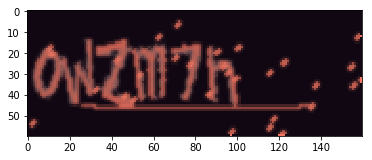

In [46]:
show_output(0)

the final captcha is: ['Q']


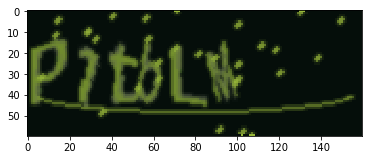

In [47]:
show_output(1)

the final captcha is: ['Q']


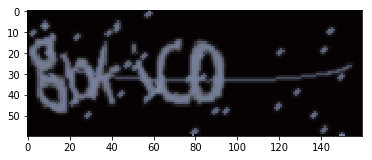

In [48]:
show_output(2)

the final captcha is: ['Q']


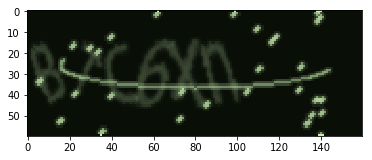

In [49]:
show_output(3)

the final captcha is: ['Q']


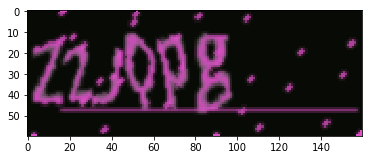

In [50]:
show_output(4)

the final captcha is: ['Q']


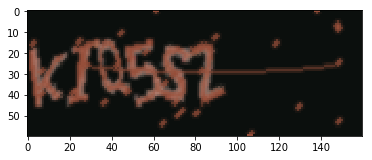

In [51]:
show_output(5)

the final captcha is: ['Q']


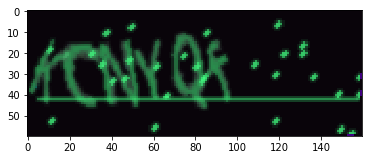

In [52]:
show_output(6)

the final captcha is: ['Q']


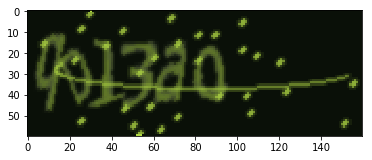

In [53]:
show_output(7)

the final captcha is: ['Q']


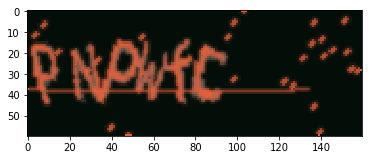

In [54]:
show_output(8)

# weird error will resolve it soon

# Highly inaccurate, will train on more data